In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

In [3]:
# Load data
mnist_data = fetch_openml("mnist_784")
x = mnist_data["data"]
y = mnist_data["target"]

# Normalize
x /= 255.0

# One-hot encode labels
num_labels = 10
examples = y.shape[0]

# Convert 'y' to numpy array
y_array = np.array(y.astype('int32'))

# Define the one_hot function
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

# Apply one-hot encoding
y_new = one_hot(y_array, num_labels)

# Split, reshape, and shuffle
train_size = 60000
test_size = x.shape[0] - train_size
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y_new[:train_size], y_new[train_size:]

# Convert x_train and y_train to NumPy arrays (if they are not already)
x_train = np.array(x_train)
y_train = np.array(y_train)

# Shuffle the training data
shuffle_index = np.random.permutation(train_size)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

# Now x_train and y_train are ready to be used for training your model

Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


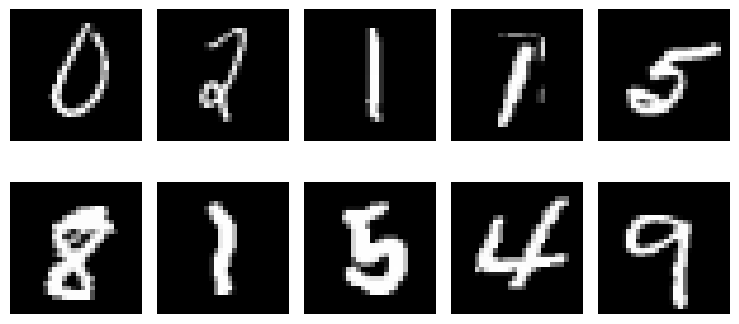

In [4]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

In [5]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        
        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")
        
        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}
        
    def relu(self, x, derivative=False):
        '''
            Derivative of ReLU is a bit more complicated since it is not differentiable at x = 0
        
            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0

            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)
            
            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer=self.sizes[1]
        output_layer=self.sizes[2]
        
        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
            "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1./input_layer),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
            "b2": np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)
        }
        return params
    
    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]
    
    def back_propagate(self, y, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        current_batch_size = y.shape[0]
        
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return self.grads
    
    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
        return l
                
    def optimize(self, l_rate=0.1, beta=.9):
        '''
            Stochatic Gradient Descent (SGD):
            θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
            Momentum:
            v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
            θ^(t+1) <- θ^t - ηv^(t+1)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]
        else:
            raise ValueError("Optimizer is currently not support, please use 'sgd' or 'momentum' instead.")

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
        
        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        
        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                # Forward
                output = self.feed_forward(x)
                # Backprop
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta)

            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)
            
                        # Assuming test_loss is a Series or NumPy array with multiple values
            if isinstance(test_loss, pd.Series):
                test_loss = test_loss.mean()  # Use mean, or choose another method
            elif isinstance(test_loss, np.ndarray):
                test_loss = np.mean(test_loss)  # Use mean, or choose another method

            # print("Test Loss:", test_loss)
            # print("Shape of Test Loss:", test_loss.shape)

           
            # Ensure that accuracy and loss are scalars
            # Ensure scalar conversion if needed
            # Assuming these variables might be Series or arrays
            train_acc = train_acc.item() if isinstance(train_acc, pd.Series) else train_acc
            train_loss = train_loss.item() if isinstance(train_loss, pd.Series) else train_loss
            test_acc = test_acc.item() if isinstance(test_acc, pd.Series) else test_acc
            test_loss = test_loss.mean() if isinstance(test_loss, (pd.Series, np.ndarray)) else test_loss  # Using mean

            # Print the results
            template = "Epoch: {} | Time: {:.2f}s | Train Acc: {:.4f} | Train Loss: {:.4f} | Test Acc: {:.4f} | Test Loss: {:.4f}"
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))





In [6]:
# Sigmoid + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=4, beta=.9)

/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 1 | Time: 3.00s | Train Acc: 0.9554 | Train Loss: 0.1499 | Test Acc: 0.9523 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 2 | Time: 5.76s | Train Acc: 0.9689 | Train Loss: 0.1018 | Test Acc: 0.9643 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 3 | Time: 7.90s | Train Acc: 0.9719 | Train Loss: 0.0903 | Test Acc: 0.9635 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 4 | Time: 11.57s | Train Acc: 0.9772 | Train Loss: 0.0733 | Test Acc: 0.9694 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 5 | Time: 14.55s | Train Acc: 0.9846 | Train Loss: 0.0512 | Test Acc: 0.9718 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 6 | Time: 19.59s | Train Acc: 0.9872 | Train Loss: 0.0437 | Test Acc: 0.9722 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 7 | Time: 24.06s | Train Acc: 0.9874 | Train Loss: 0.0407 | Test Acc: 0.9722 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 8 | Time: 26.56s | Train Acc: 0.9908 | Train Loss: 0.0335 | Test Acc: 0.9752 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 9 | Time: 30.38s | Train Acc: 0.9912 | Train Loss: 0.0311 | Test Acc: 0.9750 | Test Loss: 0.0000
Epoch: 10 | Time: 32.87s | Train Acc: 0.9934 | Train Loss: 0.0245 | Test Acc: 0.9761 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [7]:
# ReLU + SGD
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.05)

/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 1 | Time: 2.26s | Train Acc: 0.8907 | Train Loss: 0.3955 | Test Acc: 0.8941 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 2 | Time: 4.19s | Train Acc: 0.9052 | Train Loss: 0.3293 | Test Acc: 0.9098 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 3 | Time: 5.51s | Train Acc: 0.9118 | Train Loss: 0.3044 | Test Acc: 0.9153 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 4 | Time: 7.42s | Train Acc: 0.9161 | Train Loss: 0.2886 | Test Acc: 0.9202 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 5 | Time: 9.10s | Train Acc: 0.9194 | Train Loss: 0.2796 | Test Acc: 0.9203 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 6 | Time: 11.36s | Train Acc: 0.9227 | Train Loss: 0.2688 | Test Acc: 0.9251 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 7 | Time: 13.40s | Train Acc: 0.9243 | Train Loss: 0.2630 | Test Acc: 0.9227 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 8 | Time: 15.65s | Train Acc: 0.9258 | Train Loss: 0.2567 | Test Acc: 0.9264 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 9 | Time: 17.45s | Train Acc: 0.9282 | Train Loss: 0.2516 | Test Acc: 0.9256 | Test Loss: 0.0000
Epoch: 10 | Time: 19.60s | Train Acc: 0.9283 | Train Loss: 0.2503 | Test Acc: 0.9254 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [8]:
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.05)

/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 1 | Time: 2.35s | Train Acc: 0.8019 | Train Loss: 0.9558 | Test Acc: 0.8119 | Test Loss: 0.0001


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 2 | Time: 5.79s | Train Acc: 0.8606 | Train Loss: 0.6062 | Test Acc: 0.8696 | Test Loss: 0.0001


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 3 | Time: 8.38s | Train Acc: 0.8810 | Train Loss: 0.4819 | Test Acc: 0.8884 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 4 | Time: 10.29s | Train Acc: 0.8882 | Train Loss: 0.4205 | Test Acc: 0.8954 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 5 | Time: 11.85s | Train Acc: 0.8971 | Train Loss: 0.3819 | Test Acc: 0.9024 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 6 | Time: 14.80s | Train Acc: 0.9018 | Train Loss: 0.3570 | Test Acc: 0.9054 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 7 | Time: 16.53s | Train Acc: 0.9061 | Train Loss: 0.3384 | Test Acc: 0.9100 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 8 | Time: 18.77s | Train Acc: 0.9087 | Train Loss: 0.3241 | Test Acc: 0.9145 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Epoch: 9 | Time: 20.99s | Train Acc: 0.9113 | Train Loss: 0.3128 | Test Acc: 0.9160 | Test Loss: 0.0000
Epoch: 10 | Time: 23.12s | Train Acc: 0.9141 | Train Loss: 0.3028 | Test Acc: 0.9176 | Test Loss: 0.0000


/home/yuvigupta/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


## Good exercises in NumPy
You might have noticed that the code is very readable, but takes up a lot of space and could be optimized to run in loops. Here is a chance to optimize and improve the code. For example, you can optimize the forward and backward pass, such that they run in a for loop in each function. This makes the code easier to modify and possibly easier to maintain. 

More challenging exercises including implement any other activation function from this overview of activation functions, and remember to implement the derivatives as well. Different optimizers, e.g. Adam, RMSProp, etc, are also worth to try.

## Reference 
1. [CS565600 Deep Learning](https://nthu-datalab.github.io/ml/index.html), National Tsing Hua University
2. [Building a Neural Network from Scratch: Part 1](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/)
3. [Building a Neural Network from Scratch: Part 2](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%202/)
4. [Neural networks from scratch](https://developer.ibm.com/technologies/artificial-intelligence/articles/neural-networks-from-scratch), IBM Developer
5. [The Softmax Function Derivative (Part 1)](https://aimatters.wordpress.com/2019/06/17/the-softmax-function-derivative/)